In [3]:
# Import relevant libraries 

import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error
#from scikitplot.metrics import plot_roc

In [51]:
warnings.filterwarnings("ignore")

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

#plt.style.use('seaborn-v0_8-colorblind')
#plt.style.use('default')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.style.use('seaborn-pastel')


In [6]:
#Define configs

class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

In [7]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(CFG.SEED)

In [8]:
# Define paths
DATASET_PATH = "/kaggle/input/nlp-sentiments-analysis"
TRAIN_CSV = '/kaggle/input/nlp-sentiments-analysis/train.csv'
TEST_CSV = '/kaggle/input/nlp-sentiments-analysis/test.csv'
SAMPLE_SUB_CSV = '/kaggle/input/nlp-sentiments-analysis/sample_submission.csv'

In [9]:
# Load the csv files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
submission_df = pd.read_csv(SAMPLE_SUB_CSV) 

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [11]:
train_df.head(5)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [15]:
# view random selected data

def view_samples(df, count=5):
    idx = random.sample(train_df.index.to_list(), count)
    print('=========================================\n')
    for _ in idx:
        print(f'id:\t{df.Id[_]}\n')
        print(f'Review:\n{df.Review[_]}\n')
        print(f'Rating:\n{df.Rating[_]}')
        print('=========================================\n')

In [16]:
# view randomly selected data

view_samples(train_df, count=5)


id:	14754

Review:
Have been using Vodaphone for quite a long time now probably more than 10 years for the mobile phone and almost 4 years for broadband as i am always a loyal customer and have no issues until recently, last month when I asked my broadband connection to be moved to our new current address. First request done over the phone, but there was a problem of sorth that they don't know when i called back and that order was already cancelled, chatted over TOBI chat ( for almost 2.5 hrs, what a waste of time for me, it could be done quickly and easier over the phone, again a waste of manpower for the vodaphone) Tyler had confirmed and promised that this will not happened again as everything was in place and 30th of August was my connection/activation date, waited during the connection date but no engineers turned up, no message , e mail or text to inform me that the order was cancelled for no reason and found this up when I call back. Disappointing to talk to somebody over the l

In [26]:
train_distribution = train_df['Rating'].value_counts().sort_values()
train_distribution

Rating
2     1629
3     1679
4     3350
1    18663
5    34679
Name: count, dtype: int64

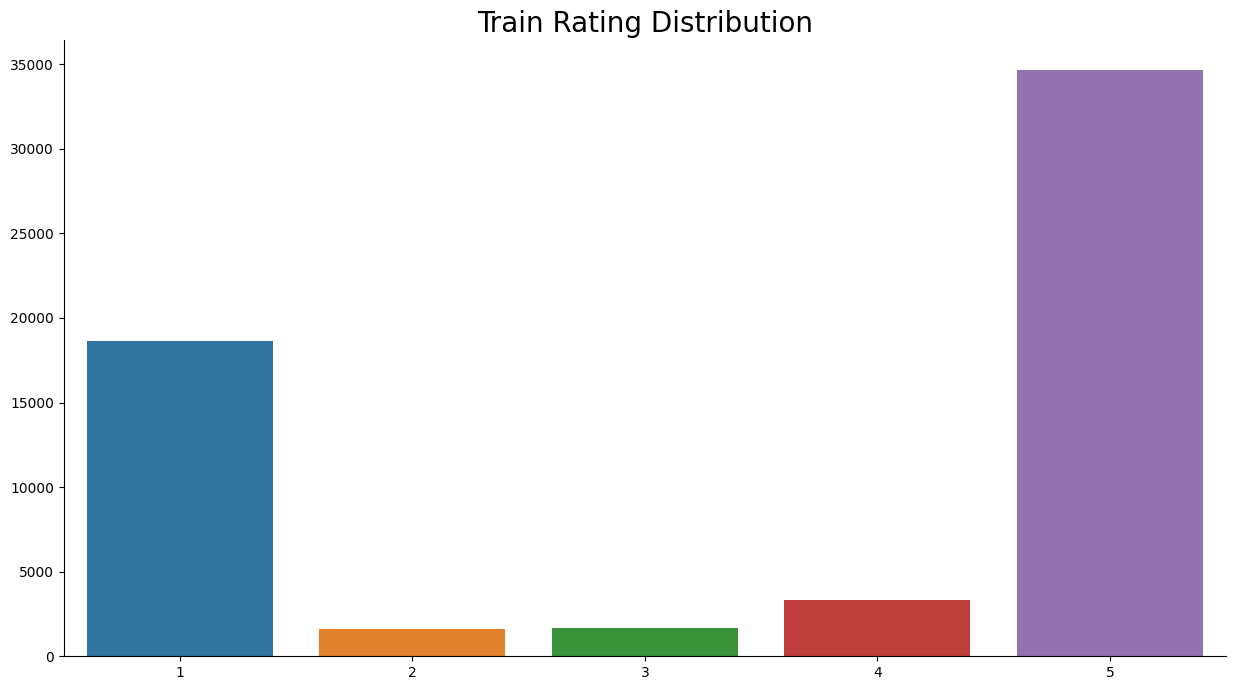

In [31]:
# View Train Rating Distribution
plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train_df['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

sns.despine();

In [32]:
# Get the lengths of each review
train_df['review_length'] = [len(_) for _ in train_df.Review]

# Get the number of tokens per review 
train_df['token_count'] = [len(_.split()) for _ in train_df.Review]

In [33]:
train_df.head(5)

,Id,Review,Rating,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,89,18
1,1,After 6 month still can't access my account,3,43,8
2,2,I couldn't make an official review on a produc...,1,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49


In [41]:
print(f"{train_df['review_length'].describe()}")

count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [42]:
print(f"{train_df['token_count'].describe()}")

count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


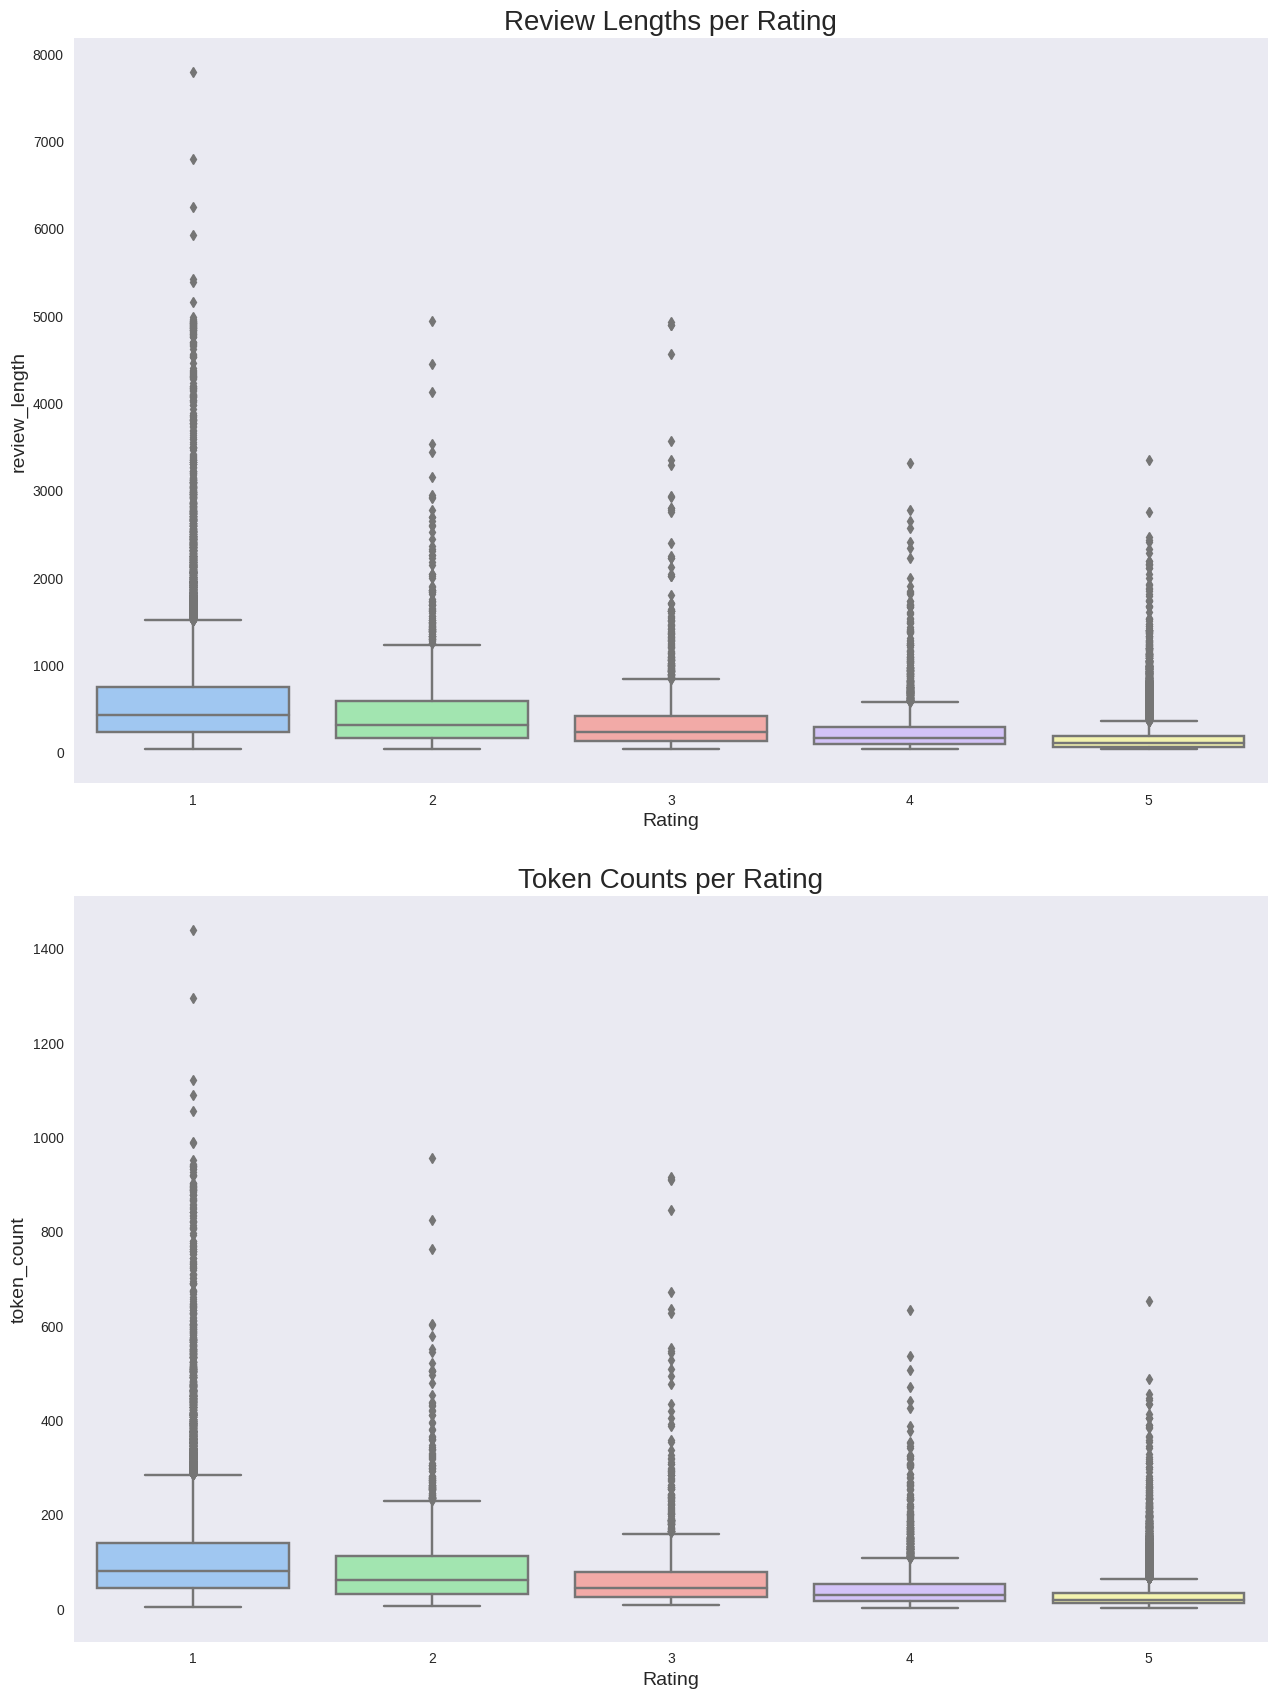

In [52]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.boxplot(data=train_df, y='review_length', x='Rating',
            ax=ax1)
ax1.set_xlabel('Rating', fontsize=14)
ax1.set_ylabel('review_length', fontsize=14)
sns.despine();

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.boxplot(data=train_df, y='token_count', x='Rating',
            ax=ax2);
ax2.set_xlabel('Rating', fontsize=14)
ax2.set_ylabel('token_count', fontsize=14)
sns.despine();

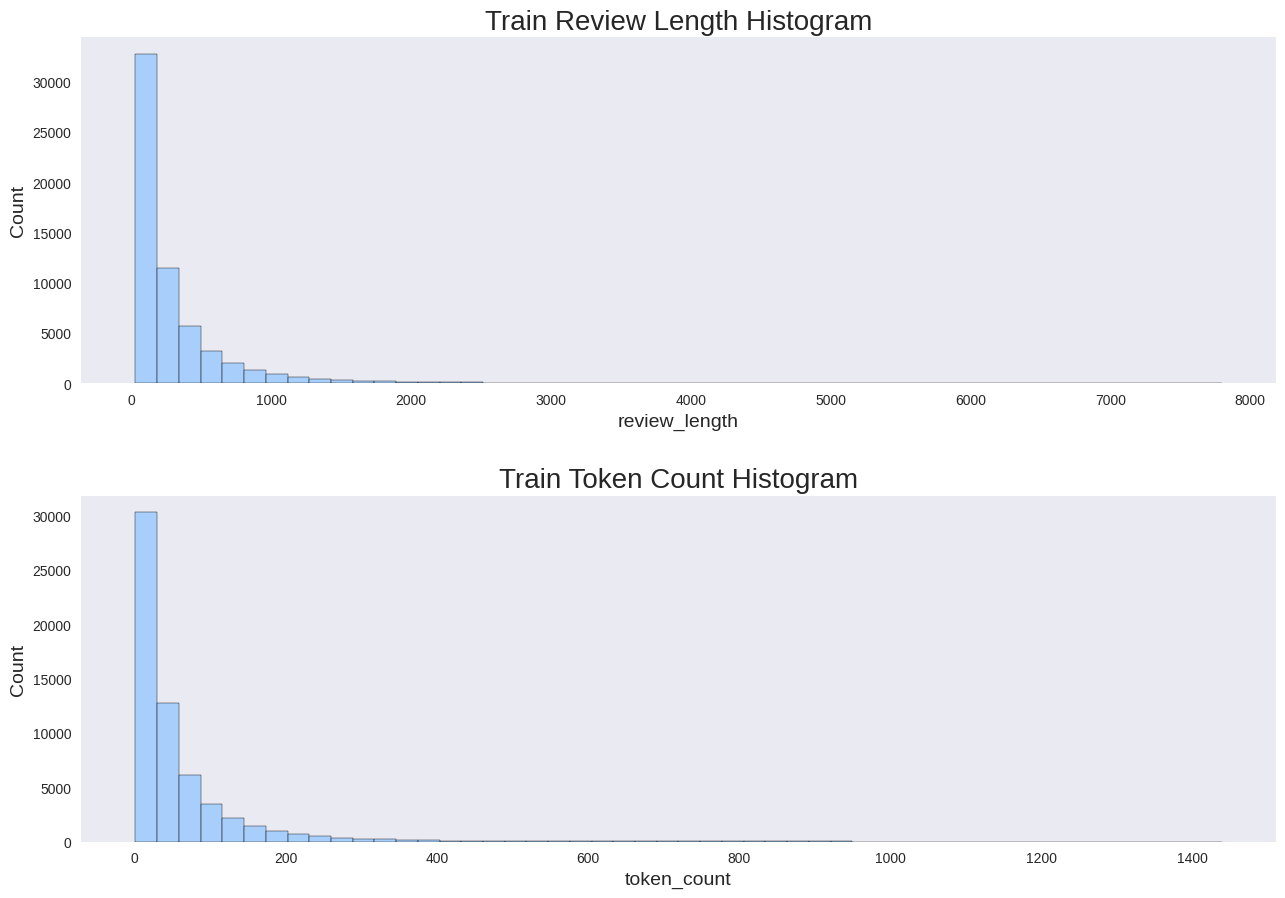

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train_df, x='review_length', bins=50,
            ax=ax1)
ax1.set_xlabel('review_length', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
sns.despine();

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train_df, x='token_count', bins=50,
            ax=ax2)
ax2.set_xlabel('token_count', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
sns.despine();